In [1]:
import os, re, datetime, json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

ddir  = r"/home/mateusz/projects/szczecin_analysis/data/"

In [2]:
files = os.listdir(ddir)
# Filter files
data = {
    'file': [],
    'date': [],
    'lines':[]
        }
for f in files:
    if not re.match("^szczecin_[0-9]+\.jl", f):
        continue
    data['file'].append(f)
    date = datetime.datetime.strptime(f[9:15], "%d%m%y").date()
    data['date'].append(date)
    num_lines = sum(1 for line in open(os.path.join(ddir, f)))
    data['lines'].append(num_lines)

In [3]:
df = pd.DataFrame(data)
df = df[df['lines'] > 1000]
df = df.sort_values(by='date')
# df = df.set_index('date')
df.describe()

,lines
count,70.000000
mean,5571.257143
std,1561.220469
min,1604.000000
25%,4672.750000
50%,6150.000000
75%,6802.750000
max,7675.000000


In [4]:
df.head()

,date,file,lines
76,2016-10-01,szczecin_011016.jl,7675
16,2016-10-09,szczecin_091016.jl,7538
65,2016-10-17,szczecin_171016.jl,7515
30,2016-10-23,szczecin_231016.jl,7648
24,2016-10-31,szczecin_311016.jl,7334


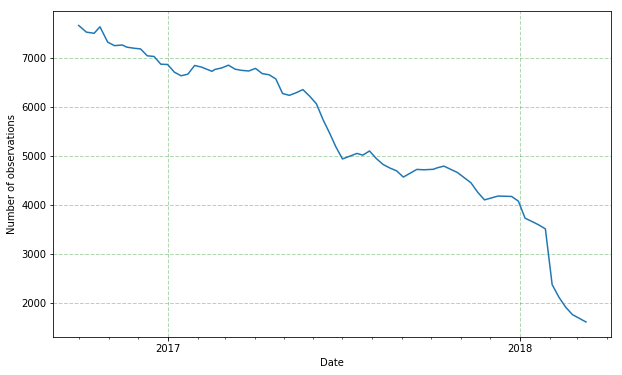

In [5]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot(df['date'], df['lines'])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.set_ylabel('Number of observations')
ax.set_xlabel('Date')
ax.grid(color='g', linestyle='--', linewidth=1, alpha=.3)

# Analyze single date

In [6]:
f = df['file'].loc[0]

data = pd.read_json(os.path.join(ddir,f), lines=True)
data.head()

,_type,data_lat,data_lon,description,details,floor,location,poi_lat,poi_lon,pow,price,rooms,sellType,town,url
0,HomespiderItem,53.422274,14.548086,"[Mieszkanie, 104 m², Szczecin]",Bardzo ładne mieszkanie usytuowane na pierwszy...,1,"Mieszkanie na sprzedaż, Szczecin, Centrum",53.4209,14.5494,104.00,430000.0,4,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-104-m-...
1,HomespiderItem,53.438730,14.520610,"[Mieszkanie, 41 m², Szczecin]",Mieszkanie po generalnym remoncie na pierwszym...,1,"Mieszkanie na sprzedaż, Szczecin, Pogodno",53.4391,14.5195,41.00,215000.0,2,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-41-m-s...
2,HomespiderItem,53.446900,14.500140,"[Mieszkanie, 50,31 m², Szczecin]",Na sprzedaż mieszkanie 3 pokojowe w bloku z la...,2,"Mieszkanie na sprzedaż, Szczecin, Pogodno",53.4448,14.4969,50.31,209000.0,3,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-50-31-...
3,HomespiderItem,53.464587,14.542620,"[Mieszkanie, 57 m², Szczecin]",Na sprzedaż bardzo ciepłe i słoneczne mieszkan...,2,"Mieszkanie na sprzedaż, Szczecin, Warszewo, DU...",53.463,14.5423,57.00,319000.0,2,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-57-m-s...
4,HomespiderItem,53.393680,14.515250,"[Mieszkanie, 38 m², Szczecin]",Na sprzedaż mieszkanie położone niedaleko Jasn...,parter,"Mieszkanie na sprzedaż, Szczecin",53.3967,14.523,38.00,219000.0,2,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-38-m-s...


In [7]:
data.tail()

,_type,data_lat,data_lon,description,details,floor,location,poi_lat,poi_lon,pow,price,rooms,sellType,town,url
6877,HomespiderItem,53.378728,14.663087,"[Mieszkanie, 70,81 m², Szczecin]","Mieszkanie czteropokojowe z balkonem, wyremont...",parter,"Mieszkanie na sprzedaż, Szczecin, Majowe",53.3788,14.6605,70.81,338000.0,4,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-70-81-...
6878,HomespiderItem,53.460000,14.510000,"[Mieszkanie, 101,20 m², Szczecin]",Przestronne mieszkanie na parterze w zabytkow...,parter,"Mieszkanie na sprzedaż, Szczecin, Pogodno, Mię...",53.4588,14.5029,101.20,467000.0,5,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-101-20...
6879,HomespiderItem,53.436208,14.527138,"[Mieszkanie, 94 m², Szczecin]",Mieszkanie (94 m2) 4-pokojowe + tzw. slużbówk...,3,"Mieszkanie na sprzedaż, Szczecin, Śródmieście",53.434,14.529,94.00,420000.0,4,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-94-m-s...
6880,HomespiderItem,53.424040,14.543747,"[Mieszkanie, 130 m², Szczecin]",Mieszkanie czteropokojowe w kamienicy w Centru...,2,"Mieszkanie na sprzedaż, Szczecin, Centrum",53.425,14.5463,130.00,375000.0,4,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-130-m-...
6881,HomespiderItem,0.000000,0.000000,"[Mieszkanie, 50,13 m², Szczecin]","Ładne,bardzo funkcjonalne mieszkanie w standar...",parter,"Mieszkanie na sprzedaż, Szczecin, Mierzyn",,,50.13,201507.0,2,Mieszkanie na sprzedaż,Szczecin,https://www.otodom.pl/oferta/mieszkanie-50-13-...


In [8]:
data.describe()

,data_lat,data_lon,pow,price,rooms
count,6882.000000,6882.000000,6882.000000,6.882000e+03,6882.000000
mean,52.777923,14.373185,68.037601,2.949679e+05,2.738593
std,5.867606,1.602288,29.044686,1.287693e+05,0.984012
min,0.000000,0.000000,11.000000,4.900000e+04,1.000000
25%,53.417965,14.520610,47.600000,2.150000e+05,2.000000
50%,53.432830,14.545285,62.000000,2.713338e+05,3.000000
75%,53.445930,14.554139,82.482500,3.490000e+05,3.000000
max,54.524587,18.960000,323.950000,2.500000e+06,9.000000


In [9]:
data['floor'].value_counts()

1           1518
4           1339
2           1190
parter      1183
3           1074
5            153
6            117
10            70
8             63
9             51
7             49
> 10          44
poddasze       8
2              6
3              4
1              3
4              3
10             2
11             2
8              1
5              1
6              1
Name: floor, dtype: int64

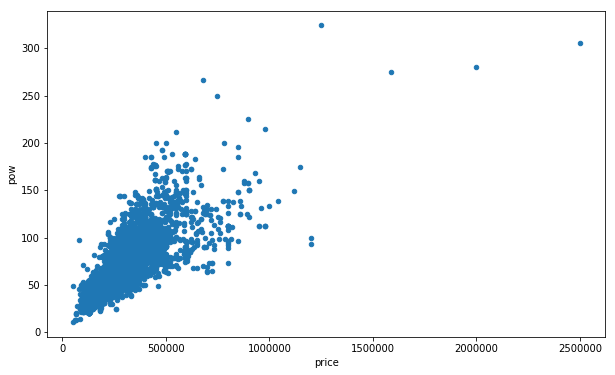

In [10]:
data.plot.scatter('price', 'pow')

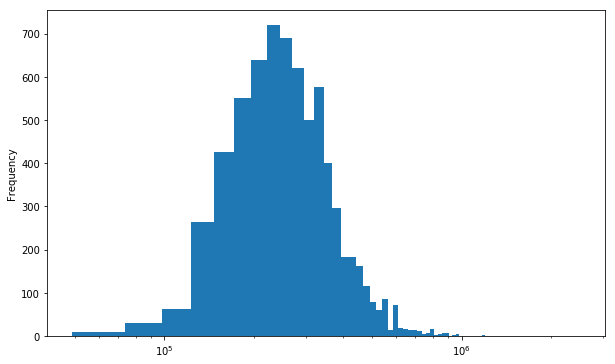

In [11]:
data['price'].plot.hist(bins=100, logx=True)